<a href="https://colab.research.google.com/github/Ruhi-Sharmin-1/C-code/blob/main/hyperparamter_tuning_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing necessary libraries
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.svm import SVC
from scipy.io import savemat
from scipy.io import loadmat
import timeit
import numpy as np
import pandas as pd

In [1]:
#loading data from google drive
from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
loaddir_data=F"/content/gdrive/My Drive/ml-ruhi/"

data = loadmat(loaddir_data + 'challenge_training2017_cases_normal_ecg_corr_metrics.mat',squeeze_me=True)
training_normal_features = data['all_corr_metrics'][:,:]
n_training_normal = np.shape(training_normal_features)[0]

data = loadmat(loaddir_data + 'challenge_training2017_cases_afib_ecg_corr_metrics.mat',squeeze_me=True)
training_afib_features = data['all_corr_metrics'][:,:]
n_training_afib = np.shape(training_afib_features)[0]

data = loadmat(loaddir_data + 'challenge_training2017_cases_noisy_ecg_corr_metrics.mat',squeeze_me=True)
training_noisy_features = data['all_corr_metrics'][:,:]
n_training_noisy = np.shape(training_noisy_features)[0]

data = loadmat(loaddir_data + 'challenge_training2017_cases_other_ecg_corr_metrics.mat',squeeze_me=True)
training_other_features = data['all_corr_metrics'][:,:]
n_training_other = np.shape(training_other_features)[0]

In [4]:
training_normal_features.shape

(5050, 48)

In [5]:
# append the training datasets and learning datasets
training_features = np.concatenate((training_normal_features,training_afib_features,training_noisy_features,training_other_features),axis=0)
training_labels = np.concatenate((np.zeros(n_training_normal),np.ones(n_training_afib),2*(np.ones(n_training_noisy)),3*(np.ones(n_training_other))))

In [6]:
#remove NAN values
def nanremove(x, y):
  # input x is training_features, y is labels
  if np.argwhere(np.isnan(x)).shape[0]==0:
    return x,y
  else:
    l=np.argwhere(np.isnan(x)).shape[0]
    u=np.argwhere(np.isnan(x))
    
    for i in range(l):      
      x = np.delete(x, (u[i,0]-i), axis=0)
      y = np.delete(y, (u[i,0]-i), axis=0)
    return x,y
    
x,y=nanremove(training_features, training_labels)

In [7]:
training_all = np.concatenate((x, y.reshape((-1,1))),axis=1)
np.random.shuffle(training_all)  #adds randomness
training_features = training_all[:,:-1]
training_labels = training_all[:,-1]

In [8]:
max_abs_mean=0
col_maxabsmean=0
for i in range(training_features.shape[1]):
  meanabscur=mean(abs(training_features[:,i]))
  if(meanabscur>max_abs_mean):
    max_abs_mean=meanabscur
    col_maxabsmean=i


In [9]:
col_maxabsmean

24

In [10]:
training_features[5:15,:]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.76923077e+00,  3.86895476e-01,  1.14338305e+

In [11]:
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#Lets start by importing the required libraries and loading the data:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
#from sklearn import cross_validation
#from sklearn import metrics   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


In [12]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [13]:
from sklearn import model_selection
#from sklearn.linear_model import LogisticRegression
test_size = 0.01 # from 0.01 to 0.1
seed = 4 #change from 4 to 5
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(training_features, training_labels, test_size=test_size, random_state=seed)

In [14]:
model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=140, slient=True, min_child_weight=1, objective='multi:softmax', gamma=0, reg_alpha=0, reg_lambda=1)
param_grid = {
    'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

model, pred = algorithm_pipeline(X_train, X_test, Y_train, Y_test, model, 
                                 param_grid, cv=2)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
1.340020327272967
{'max_depth': 9, 'min_child_weight': 5}


In [ ]:
model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=140, slient=True, min_child_weight=1, objective='multi:softmax', gamma=0, reg_alpha=0, reg_lambda=1)
param_grid = {
    'max_depth':[8,9,10],
 'min_child_weight':[1,2]
}

model, pred = algorithm_pipeline(X_train, X_test, Y_train, Y_test, model, 
                                 param_grid, cv=2)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
1.3384676385092167
{'max_depth': 10, 'min_child_weight': 2}


In [ ]:
model = xgb.XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=140, slient=True, min_child_weight=1, objective='multi:softmax', gamma=0, reg_alpha=0, reg_lambda=1)
param_grid = {
    'gamma':[i/10.0 for i in range(0,5)]
}

model, pred = algorithm_pipeline(X_train, X_test, Y_train, Y_test, model, 
                                 param_grid, cv=2)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
1.3364476517194879
{'gamma': 0.2}


In [ ]:
model = xgb.XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=140, slient=True, min_child_weight=1, objective='multi:softmax', gamma=0.2, subsample=0.8, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1)
param_grid = {
    'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

model, pred = algorithm_pipeline(X_train, X_test, Y_train, Y_test, model, 
                                 param_grid, cv=2)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
1.3422104760692264
{'colsample_bytree': 0.8, 'subsample': 0.9}


In [ ]:
model = xgb.XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=140, slient=True, min_child_weight=1, objective='multi:softmax', gamma=0.2, subsample=0.9, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1)
param_grid = {
    'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}

model, pred = algorithm_pipeline(X_train, X_test, Y_train, Y_test, model, 
                                 param_grid, cv=2)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
1.3400728914158202
{'reg_lambda': 1e-05}


In [ ]:
model = xgb.XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=140, slient=True, min_child_weight=1, objective='multi:softmax', gamma=0.2, subsample=0.9, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1e-5)
param_grid = {
    'n_estimators': [100,200,300,400, 500,600,700,800,900, 1000]
}

model, pred = algorithm_pipeline(X_train, X_test, Y_train, Y_test, model, 
                                 param_grid, cv=2)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
1.3287803278416352
{'n_estimators': 1000}


In [ ]:
model = xgb.XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=140, slient=True, min_child_weight=1, objective='multi:softmax', gamma=0.2, subsample=0.9, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1e-5)
param_grid = {
    'n_estimators': [1000, 3000, 5000]
}

model, pred = algorithm_pipeline(X_train, X_test, Y_train, Y_test, model, 
                                 param_grid, cv=2)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
1.3258451394206545
{'n_estimators': 5000}


In [ ]:
model = xgb.XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=1000, slient=True, min_child_weight=1, objective='multi:softmax', gamma=0.2, subsample=0.9, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1e-5)
param_grid = {
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2, 0.1]
}

model, pred = algorithm_pipeline(X_train, X_test, Y_train, Y_test, model, 
                                 param_grid, cv=2)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
1.3276734718995806
{'learning_rate': 0.1}


In [ ]:
bst = xgb.XGBClassifier(max_depth=8, learning_rate=0.1, n_estimators=1000, slient=True, min_child_weight=1, objective='multi:softmax', gamma=0.2, reg_alpha=0, reg_lambda=1e-5)
bst.fit(X_train, Y_train) #bst=model
# Fit the validation data  # model.predict for Y_predict
xgb_pred = bst.predict(X_test)  
# extracting most confident predictions
best_preds = np.round(xgb_pred)

In [ ]:
print(model)

GridSearchCV(cv=2, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7], 'max_depth': [15],
                         'n_estimators': [400], 'reg_alpha': [1.1],
                         'reg_lambda': [1.1], 'subsample': [0.7]},
             scoring='neg_mean_squared_error', verbose=2)


In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("Model Report\n")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
import xgboost as xgb
max_depth = 10
n_estimators = 110

bst = xgb.XGBClassifier(max_depth=max_depth, learning_rate=0.0001, n_estimators=n_estimators, slient=True, min_child_weight=1, objective='multi:softmax', gamma=0, reg_alpha=0, reg_lambda=1)
bst.fit(X_train, Y_train) #bst=model
# Fit the validation data  # model.predict for Y_predict
xgb_pred = bst.predict(X_test)  
# extracting most confident predictions
best_preds = np.round(xgb_pred)

#(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None,
#objective="binary:logistic", booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1,
#max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1,
#reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs) -> None

In [ ]:
xgb_pred_proba = bst.predict_proba(X_test)
print(Y_test)
print(xgb_pred_proba)
import pandas as pd 
pd.DataFrame(Y_test).to_csv(F"/content/gdrive/My Drive/ml-ruhi/XGBoost-Y-true-4class.csv")
pd.DataFrame(xgb_pred_proba).to_csv(F"/content/gdrive/My Drive/ml-ruhi/XGBoost-Y-pred-4class.csv")


In [ ]:
from sklearn.metrics import f1_score
score = f1_score(Y_test, best_preds, average='weighted')
print('F-Measure: %.3f' % score)


F-Measure: 0.653


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, best_preds)
accuracy * 100.0

68.6046511627907

In [ ]:
print('Mean ROC AUC: %.3f' % mean(score))

Mean ROC AUC: 0.777


In [ ]:
# avg F-measure
from sklearn.metrics import f1_score
score = f1_score(Y_test, best_preds, average=None)
print(score) 
score = f1_score(Y_test, best_preds, average='macro')
print(score) 
score = f1_score(Y_test, best_preds, average='weighted')
print(score) 


[0.87037037 0.86956522 0.4        0.5       ]
0.6599838969404187
0.7774931655619217


In [ ]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
cm=confusion_matrix(Y_test, best_preds)

In [ ]:
# code from https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels
def plot_conf_mat(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
target_names=['Normal', 'afib', 'noisy', 'other']

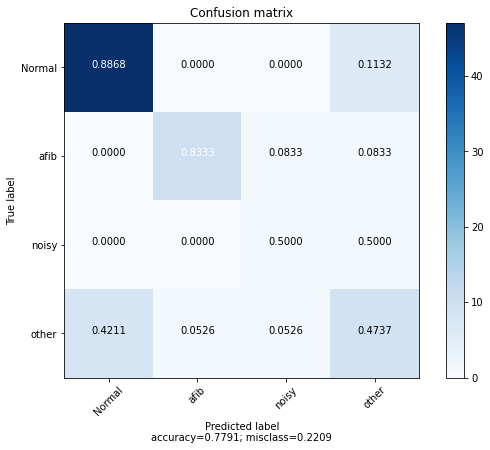

In [ ]:
plot_conf_mat(cm, target_names)

In [ ]:
#cross-validation, k=5, 